# DQN & PPO Multi-Seed Training

This notebook trains both DQN and PPO across multiple seeds, evaluates each model,
and produces per-algorithm, per-seed, and aggregated comparison charts.

---

In [1]:
import os, sys, random, time
from typing import Callable

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image, display

In [2]:
# Global Configuration

SEED_LIST = [42, 123, 999]

ALGORITHM_MAP = {
    "dqn": DQN,
    "ppo": PPO,
}

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
GYMNASIUM_MODEL = "LunarLander-v3"
MLP_POLICY = "MlpPolicy"

WIND_ENABLED = False

TOTAL_TIMESTEPS = 1_500_000
EVALUATION_EPISODES = 20

# Update live stats and plots every N episodes
CHART_UPDATE_FREQ = 10

DEVICE = "cpu"


def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.
    """
    def func(progress_remaining: float) -> float:
        """
        Progress decreases from 1 (beginning) to 0 (end)
        """
        return progress_remaining * initial_value
    return func


# Per-algorithm hyperparameters
ALGO_PARAMS = {
    "dqn": {
        "policy": MLP_POLICY,
        
        # Linear Schedule allows weights to settle perfectly at the end
        "learning_rate": linear_schedule(6.3e-4), 
        
        "learning_starts": 50_000,
        
        # Massive buffer prevents forgetting recovery maneuvers
        "buffer_size": 750_000, 
        "batch_size": 128,
        "gamma": 0.99,
        
        "exploration_fraction": 0.12,  
        
        # High final epsilon forces the agent to keep learning recoveries
        "exploration_final_eps": 0.1,  
        
        # Standard Zoo update mechanics
        "target_update_interval": 250, 
        "train_freq": 4,
        # Takes 4 gradient updates every 4 env steps
        "gradient_steps": 4,
        
        "policy_kwargs": dict(net_arch=[256, 256]),
        "device": DEVICE,
    },
    "ppo": {
        "learning_rate": 2.5e-4,
        "n_steps": 2048,
        "batch_size": 64,
        "n_epochs": 10,
        "gamma": 0.999,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "clip_range": 0.2,
    },
}

print(f"Algorithms: {list(ALGORITHM_MAP.keys())}")
print(f"Seeds: {SEED_LIST}")
print(f"Wind enabled: {WIND_ENABLED}")
print(f"Total timesteps per seed: {TOTAL_TIMESTEPS:,}")
print(f"Evaluation episodes per seed: {EVALUATION_EPISODES}")
print(f"Chart update frequency: every {CHART_UPDATE_FREQ} episodes")
print(f"Device: {DEVICE}")

Algorithms: ['dqn', 'ppo']
Seeds: [42, 123, 999]
Wind enabled: False
Total timesteps per seed: 1,500,000
Evaluation episodes per seed: 20
Chart update frequency: every 10 episodes
Device: cpu


In [3]:
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Device:", DEVICE)
print("CUDA:", torch.version.cuda if torch.cuda.is_available() else "None")

Python: 3.12.3
PyTorch: 2.10.0+cu130
Device: cpu
CUDA: 13.0


In [4]:
# Environment inspection (run once)
env_tmp = gym.make(GYMNASIUM_MODEL)

print("Observation space:", env_tmp.observation_space)
print("Action space:", env_tmp.action_space)

obs, info = env_tmp.reset()
print("Initial observation:", obs)

env_tmp.close()

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Initial observation: [-0.00506516  1.3994136  -0.51306254 -0.51140976  0.00587606  0.11621626
  0.          0.        ]


In [5]:
class DQNLoggingCallback(BaseCallback):

    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.value_loss = []
        self.entropy = []
        self.mean_q_values = []      # Track Q-value overestimation
        self.gradient_updates = 0    # Count gradient updates

        self._current_reward = 0.0
        self._current_length = 0
        self._plot_handle = None
        self._stats_handle = None

    def _on_step(self) -> bool:
        rewards = self.locals.get("rewards")
        dones = self.locals.get("dones")

        if rewards is not None and dones is not None:
            reward = rewards[0]
            done = dones[0]

            self._current_reward += float(reward)
            self._current_length += 1

            if done:
                self.episode_rewards.append(self._current_reward)
                self.episode_lengths.append(self._current_length)
                ep = len(self.episode_rewards)

                if ep % CHART_UPDATE_FREQ == 0:
                    recent = np.array(self.episode_rewards[-50:])
                    stats_text = (
                        f'Episode {ep} | Last {len(recent)} Ep \u2014 '
                        f'Mean: {np.mean(recent):.1f} | Std: {np.std(recent):.1f} | '
                        f'Min: {np.min(recent):.1f} | Max: {np.max(recent):.1f} | '
                        f'Success: {(recent >= 200).sum() / len(recent) * 100:.0f}%'
                    )
                    if self._stats_handle is None:
                        self._stats_handle = display(stats_text, display_id=True)
                    else:
                        self._stats_handle.update(stats_text)

                if ep % CHART_UPDATE_FREQ == 0:
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

                    ax1.plot(self.episode_rewards, alpha=0.3, color='gray')
                    window = min(50, len(self.episode_rewards))
                    rolling = pd.Series(self.episode_rewards).rolling(window).mean()
                    ax1.plot(rolling, color='blue', linewidth=2)
                    ax1.axhline(y=200, color='red', linestyle='--')
                    ax1.set_title(f'Episode Reward \u2014 Ep {ep}')
                    ax1.set_xlabel('Episode')
                    ax1.set_ylabel('Reward')
                    ax1.grid(True, alpha=0.3)

                    if self.value_loss:
                        ax2.plot(self.value_loss, color='green', alpha=0.7)
                        ax2.set_title('Value Loss')
                        ax2.set_xlabel('Rollout')
                        ax2.set_ylabel('Loss')
                        ax2.grid(True, alpha=0.3)

                    plt.tight_layout()

                    if self._plot_handle is None:
                        self._plot_handle = display(fig, display_id=True)
                    else:
                        self._plot_handle.update(fig)
                    plt.close(fig)

                self._current_reward = 0.0
                self._current_length = 0

        return True

    def _on_rollout_end(self) -> None:
        logger_data = self.model.logger.name_to_value
        if "train/loss" in logger_data:
            self.value_loss.append(logger_data["train/loss"])
        if "rollout/exploration_rate" in logger_data:
            self.entropy.append(logger_data["rollout/exploration_rate"])
        if "train/n_updates" in logger_data:
            self.gradient_updates = int(logger_data["train/n_updates"])

        # Sample Q-values from current observation to track overestimation
        try:
            obs = self.locals.get("new_obs")
            if obs is not None:
                obs_tensor = torch.as_tensor(obs, device=self.model.device).float()
                dqn_model: DQN = self.model  # type: ignore[assignment]
                with torch.no_grad():
                    q_values = dqn_model.q_net(obs_tensor)
                self.mean_q_values.append(float(q_values.max(dim=1).values.mean()))
        except Exception:
            pass


class PPOLoggingCallback(BaseCallback):
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.policy_loss = []
        self.value_loss = []
        self.entropy = []
        self.clip_fraction = []       # PPO stability: fraction of clipped updates
        self.approx_kl = []           # PPO stability: KL divergence
        self.explained_variance = []  # PPO stability: value function quality
        self.gradient_updates = 0     # Count gradient updates

        self._current_rewards: np.ndarray = np.array([])
        self._current_lengths: np.ndarray = np.array([])
        self._plot_handle = None
        self._stats_handle = None

    def _on_training_start(self) -> None:
        n_envs = self.training_env.num_envs
        self._current_rewards = np.zeros(n_envs, dtype=np.float32)
        self._current_lengths = np.zeros(n_envs, dtype=np.int32)

    def _on_step(self) -> bool:
        rewards = self.locals.get("rewards")
        dones = self.locals.get("dones")

        if rewards is not None and dones is not None:
            self._current_rewards += rewards
            self._current_lengths += 1

            for i, done in enumerate(dones):
                if done:
                    self.episode_rewards.append(float(self._current_rewards[i]))
                    self.episode_lengths.append(int(self._current_lengths[i]))
                    ep = len(self.episode_rewards)

                    if ep % CHART_UPDATE_FREQ == 0:
                        recent = np.array(self.episode_rewards[-50:])
                        stats_text = (
                            f'Episode {ep} | Last {len(recent)} Ep \u2014 '
                            f'Mean: {np.mean(recent):.1f} | Std: {np.std(recent):.1f} | '
                            f'Min: {np.min(recent):.1f} | Max: {np.max(recent):.1f} | '
                            f'Success: {(recent >= 200).sum() / len(recent) * 100:.0f}%'
                        )
                        if self._stats_handle is None:
                            self._stats_handle = display(stats_text, display_id=True)
                        else:
                            self._stats_handle.update(stats_text)

                    """
                    if ep % CHART_UPDATE_FREQ == 0:
                        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

                        ax1.plot(self.episode_rewards, alpha=0.3, color='gray')
                        window = min(50, len(self.episode_rewards))
                        rolling = pd.Series(self.episode_rewards).rolling(window).mean()
                        ax1.plot(rolling, color='blue', linewidth=2)
                        ax1.axhline(y=200, color='red', linestyle='--')
                        ax1.set_title(f'Episode Reward \u2014 Ep {ep}')
                        ax1.set_xlabel('Episode')
                        ax1.set_ylabel('Reward')
                        ax1.grid(True, alpha=0.3)

                        if self.value_loss:
                            ax2.plot(self.value_loss, color='green', alpha=0.7)
                            ax2.set_title('Value Loss')
                            ax2.set_xlabel('Rollout')
                            ax2.set_ylabel('Loss')
                            ax2.grid(True, alpha=0.3)

                        plt.tight_layout()

                        if self._plot_handle is None:
                            self._plot_handle = display(fig, display_id=True)
                        else:
                            self._plot_handle.update(fig)
                        plt.close(fig)
                    """

                    self._current_rewards[i] = 0
                    self._current_lengths[i] = 0
        return True

    def _on_rollout_end(self) -> None:
        logger_data = self.model.logger.name_to_value
        if "train/policy_gradient_loss" in logger_data:
            self.policy_loss.append(logger_data["train/policy_gradient_loss"])
        if "train/value_loss" in logger_data:
            self.value_loss.append(logger_data["train/value_loss"])
        if "train/entropy_loss" in logger_data:
            self.entropy.append(-logger_data["train/entropy_loss"])
        if "train/clip_fraction" in logger_data:
            self.clip_fraction.append(logger_data["train/clip_fraction"])
        if "train/approx_kl" in logger_data:
            self.approx_kl.append(logger_data["train/approx_kl"])
        if "train/explained_variance" in logger_data:
            self.explained_variance.append(logger_data["train/explained_variance"])
        if "train/n_updates" in logger_data:
            self.gradient_updates = int(logger_data["train/n_updates"])


CALLBACK_MAP = {
    "dqn": DQNLoggingCallback,
    "ppo": PPOLoggingCallback,
}

In [6]:
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


DQN | Seed 42



Output()

'Episode 5420 | Last 50 Ep — Mean: 236.2 | Std: 95.5 | Min: 15.8 | Max: 315.9 | Success: 82%'

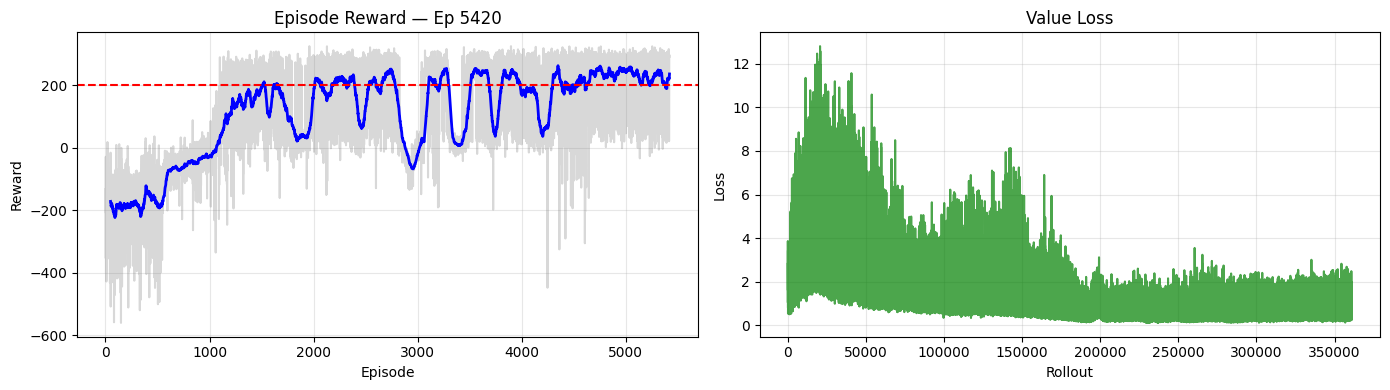

Output()

'Episode 2160 | Last 50 Ep — Mean: 231.6 | Std: 66.6 | Min: 14.2 | Max: 306.0 | Success: 74%'

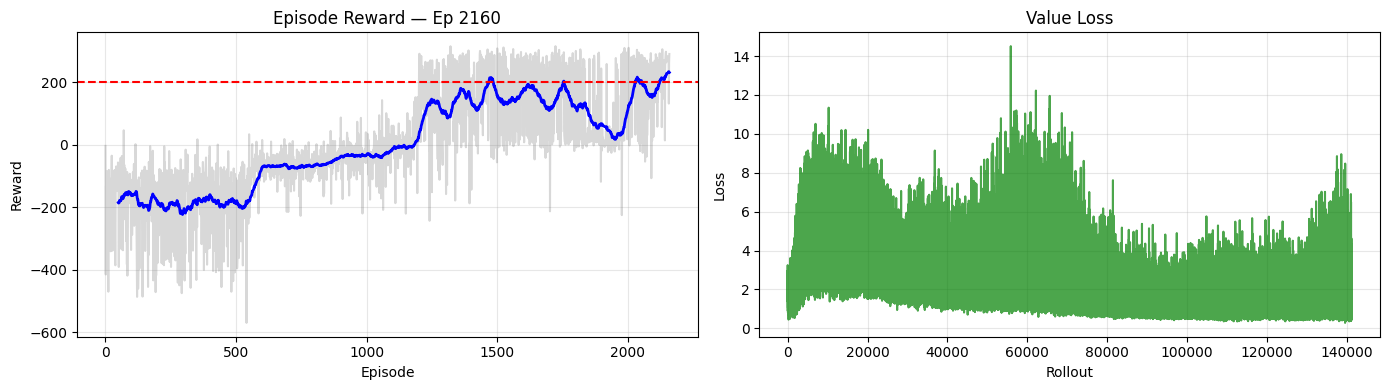

Training time: 46.9 min (2813 s)
Model saved to: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/dqn/lab007_dqn_42

DQN | Seed 123



In [ ]:
# Training loop: algorithms x seeds

training_results = {}  # {algo: {seed: callback}}
training_times = {}    # {algo: {seed: seconds}}

for algo_name, algo_class in ALGORITHM_MAP.items():

    models_dir = os.path.join(NOTEBOOK_DIR, "../../../models", algo_name)
    os.makedirs(models_dir, exist_ok=True)
    tb_dir = os.path.join(NOTEBOOK_DIR, "outputs_" + algo_name, "tensorboard")

    training_results[algo_name] = {}
    training_times[algo_name] = {}

    for seed in SEED_LIST:
        print(f"\n{'='*60}")
        print(f"{algo_name.upper()} | Seed {seed}")
        print(f"{'='*60}\n")

        set_all_seeds(seed)

        def make_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        env = DummyVecEnv([make_env])
        env.seed(seed)

        params = {
            "policy": MLP_POLICY,
            "env": env,
            "device": DEVICE,
            "seed": seed,
            "tensorboard_log": tb_dir,
            **ALGO_PARAMS[algo_name],
        }

        callback = CALLBACK_MAP[algo_name]()
        model = algo_class(**params)

        t_start = time.time()
        model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback, progress_bar=True)
        t_elapsed = time.time() - t_start

        training_times[algo_name][seed] = t_elapsed
        print(f"Training time: {t_elapsed/60:.1f} min ({t_elapsed:.0f} s)")

        save_path = os.path.join(models_dir, f"lab007_{algo_name}_{seed}")
        model.save(save_path)
        print(f"Model saved to: {save_path}")

        training_results[algo_name][seed] = callback

        env.close()

    print(f"\n{algo_name.upper()}: All {len(SEED_LIST)} seeds trained.")

print(f"\nAll training complete.")

In [ ]:
# Training Time Summary

rows = []
for algo_name in ALGORITHM_MAP:
    for seed in SEED_LIST:
        t = training_times[algo_name][seed]
        rows.append({
            "Algorithm": algo_name.upper(),
            "Seed": seed,
            "Time (s)": f"{t:.0f}",
            "Time (min)": f"{t/60:.1f}",
        })

for algo_name in ALGORITHM_MAP:
    times = list(training_times[algo_name].values())
    rows.append({
        "Algorithm": algo_name.upper(),
        "Seed": "Mean",
        "Time (s)": f"{np.mean(times):.0f}",
        "Time (min)": f"{np.mean(times)/60:.1f}",
    })

print("*** TRAINING TIME SUMMARY ***")
print(f"Timesteps per seed: {TOTAL_TIMESTEPS:,} | Device: {DEVICE}")
print()
print(pd.DataFrame(rows).to_string(index=False))

In [ ]:
# Gradient Updates Summary
# DQN: train_freq=4, gradient_steps=-1 -> 4 gradient steps every 4 env steps
# PPO: n_steps=2048, n_epochs=10, batch_size=64 -> 10 * (2048/64) = 320 updates per rollout

rows = []
for algo_name in ALGORITHM_MAP:
    # Use the actual count from the last seed's callback
    last_seed = SEED_LIST[-1]
    actual_updates = training_results[algo_name][last_seed].gradient_updates

    # Also compute analytically for verification
    if algo_name == "dqn":
        p = ALGO_PARAMS["dqn"]
        train_freq = p.get("train_freq", 4)
        grad_steps = p.get("gradient_steps", -1)
        learning_starts = p.get("learning_starts", 0)
        effective_steps = TOTAL_TIMESTEPS - learning_starts
        steps_per_call = train_freq if grad_steps == -1 else grad_steps
        analytical = (effective_steps // train_freq) * steps_per_call
    else:
        p = ALGO_PARAMS["ppo"]
        n_steps = p.get("n_steps", 2048)
        n_epochs = p.get("n_epochs", 10)
        batch_size = p.get("batch_size", 64)
        n_rollouts = TOTAL_TIMESTEPS // n_steps
        minibatches_per_epoch = n_steps // batch_size
        analytical = n_rollouts * n_epochs * minibatches_per_epoch

    rows.append({
        "Algorithm": algo_name.upper(),
        "Actual (from training)": f"{actual_updates:,}",
        "Analytical (computed)": f"{analytical:,}",
        "Total Env Steps": f"{TOTAL_TIMESTEPS:,}",
        "Ratio (updates/steps)": f"{actual_updates / TOTAL_TIMESTEPS:.3f}",
    })

print("*** GRADIENT UPDATES SUMMARY ***")
print(pd.DataFrame(rows).to_string(index=False))
print()
print("DQN: train_freq=4, gradient_steps=-1 -> 4 gradient updates per training call, called every 4 env steps")
print(f"PPO: n_steps={ALGO_PARAMS['ppo']['n_steps']}, n_epochs={ALGO_PARAMS['ppo']['n_epochs']}, "
      f"batch_size={ALGO_PARAMS['ppo']['batch_size']} -> "
      f"{ALGO_PARAMS['ppo']['n_epochs'] * (ALGO_PARAMS['ppo']['n_steps'] // ALGO_PARAMS['ppo']['batch_size'])} "
      f"updates per rollout")

In [ ]:
# Per-Algorithm, Per-Seed: Episode Reward over Training

for algo_name in ALGORITHM_MAP:
    fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
    if len(SEED_LIST) == 1:
        axes = [axes]

    for ax, seed in zip(axes, SEED_LIST):
        ax.plot(training_results[algo_name][seed].episode_rewards, alpha=0.7)
        ax.set_title(f"Seed {seed}")
        ax.set_xlabel("Episode")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Total Reward")
    fig.suptitle(f"{algo_name.upper()} \u2014 Episode Reward over Training", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Per-Algorithm, Per-Seed: Episode Length over Training

for algo_name in ALGORITHM_MAP:
    fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
    if len(SEED_LIST) == 1:
        axes = [axes]

    for ax, seed in zip(axes, SEED_LIST):
        ax.plot(training_results[algo_name][seed].episode_lengths, alpha=0.7, color="orange")
        ax.set_title(f"Seed {seed}")
        ax.set_xlabel("Episode")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Number of Steps")
    fig.suptitle(f"{algo_name.upper()} \u2014 Episode Length over Training", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Per-Algorithm, Per-Seed: Value Loss over Rollouts

for algo_name in ALGORITHM_MAP:
    fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
    if len(SEED_LIST) == 1:
        axes = [axes]

    for ax, seed in zip(axes, SEED_LIST):
        ax.plot(training_results[algo_name][seed].value_loss, alpha=0.7, color="green")
        ax.set_title(f"Seed {seed}")
        ax.set_xlabel("Rollout")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Loss Value")
    fig.suptitle(f"{algo_name.upper()} \u2014 Value Loss over Rollouts", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Per-Algorithm, Per-Seed: Entropy / Exploration Rate over Rollouts

entropy_labels = {"dqn": ("Epsilon", "Exploration Rate"), "ppo": ("Entropy (Positive)", "Entropy")}

for algo_name in ALGORITHM_MAP:
    ylabel, title_suffix = entropy_labels[algo_name]

    fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
    if len(SEED_LIST) == 1:
        axes = [axes]

    for ax, seed in zip(axes, SEED_LIST):
        ax.plot(training_results[algo_name][seed].entropy, alpha=0.7, color="purple")
        ax.set_title(f"Seed {seed}")
        ax.set_xlabel("Rollout")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel(ylabel)
    fig.suptitle(f"{algo_name.upper()} \u2014 {title_suffix} over Rollouts", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# PPO Only: Policy Loss over Rollouts

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    ax.plot(training_results["ppo"][seed].policy_loss, alpha=0.7, color="red")
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Rollout")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Policy Loss")
fig.suptitle("PPO \u2014 Policy Gradient Loss over Rollouts", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# DQN Overestimation: Mean Max Q-Value over Training

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    q_vals = training_results["dqn"][seed].mean_q_values
    if q_vals:
        ax.plot(q_vals, alpha=0.7, color="darkorange")
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Rollout")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Mean Max Q-Value")
fig.suptitle("DQN \u2014 Q-Value Overestimation Tracking", fontsize=14)
plt.tight_layout()
plt.show()

print("Note: Steadily rising Q-values that diverge from actual returns indicate overestimation.")
print("A stable or slowly growing curve suggests the target network is controlling overestimation.")

In [ ]:
# PPO Update Stability: Clip Fraction, Approx KL, Explained Variance

fig, axes = plt.subplots(3, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 12), sharex=True)
if len(SEED_LIST) == 1:
    axes = axes.reshape(3, 1)

metrics = [
    ("clip_fraction", "Clip Fraction", "tab:red",
     "Fraction of policy updates clipped by PPO. High values suggest the policy is changing too fast."),
    ("approx_kl", "Approx KL Divergence", "tab:purple",
     "KL divergence between old and new policy. Spikes indicate large policy shifts."),
    ("explained_variance", "Explained Variance", "tab:cyan",
     "How well the value function predicts returns. 1.0 = perfect, 0 = no better than mean."),
]

for row, (attr, ylabel, color, _) in enumerate(metrics):
    for col, seed in enumerate(SEED_LIST):
        data = getattr(training_results["ppo"][seed], attr)
        if data:
            axes[row][col].plot(data, alpha=0.7, color=color)
        if row == 0:
            axes[row][col].set_title(f"Seed {seed}")
        if row == 2:
            axes[row][col].set_xlabel("Rollout")
        axes[row][col].grid(True, alpha=0.3)
    axes[row][0].set_ylabel(ylabel)

fig.suptitle("PPO \u2014 Update Stability Metrics over Rollouts", fontsize=14)
plt.tight_layout()
plt.show()

for _, ylabel, _, description in metrics:
    print(f"  {ylabel}: {description}")

In [ ]:
# Aggregated: Rolling Reward Overlay — per algorithm (all seeds on one chart)

seed_colors = list(plt.colormaps["tab10"](range(10)))  # type: ignore[arg-type]

for algo_name in ALGORITHM_MAP:
    plt.figure(figsize=(14, 6))
    for i, seed in enumerate(SEED_LIST):
        rewards = training_results[algo_name][seed].episode_rewards
        rolling = pd.Series(rewards).rolling(50).mean()
        plt.plot(rolling, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

    plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
    plt.title(f"{algo_name.upper()} Training: Rolling Mean Reward (window=50)", fontsize=14)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Per-Algorithm: Rolling Success Rate over Training (window=50)

for algo_name in ALGORITHM_MAP:
    plt.figure(figsize=(14, 6))
    for i, seed in enumerate(SEED_LIST):
        rewards = np.array(training_results[algo_name][seed].episode_rewards)
        success = (rewards >= 200).astype(float)
        rolling_success = pd.Series(success).rolling(50).mean() * 100
        plt.plot(rolling_success, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

    plt.axhline(y=100, color='green', linestyle=':', alpha=0.4, label='100%')
    plt.axhline(y=50, color='gray', linestyle=':', alpha=0.4, label='50%')
    plt.title(f"{algo_name.upper()} Training: Rolling Success Rate (window=50)", fontsize=14)
    plt.xlabel("Episode")
    plt.ylabel("Success Rate (%)")
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Cross-Algorithm Comparison: Success Rate over Training (averaged across seeds)

algo_colors = {"dqn": "tab:blue", "ppo": "tab:orange"}

plt.figure(figsize=(14, 6))
for algo_name in ALGORITHM_MAP:
    min_len = min(len(training_results[algo_name][s].episode_rewards) for s in SEED_LIST)
    all_rewards = np.array([training_results[algo_name][s].episode_rewards[:min_len] for s in SEED_LIST])
    all_success = (all_rewards >= 200).astype(float)

    mean_success = pd.Series(all_success.mean(axis=0)).rolling(50).mean() * 100
    std_success = pd.Series(all_success.std(axis=0)).rolling(50).mean() * 100

    episodes = np.arange(len(mean_success))
    plt.plot(episodes, mean_success, color=algo_colors[algo_name], linewidth=2,
             label=f"{algo_name.upper()} (mean)")
    plt.fill_between(episodes, mean_success - std_success, mean_success + std_success,
                     color=algo_colors[algo_name], alpha=0.15)

plt.axhline(y=100, color='green', linestyle=':', alpha=0.4, label='100%')
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.4, label='50%')
plt.title("DQN vs PPO: Mean Success Rate across Seeds (window=50)", fontsize=14)
plt.xlabel("Episode")
plt.ylabel("Success Rate (%)")
plt.ylim(-5, 105)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Cross-Algorithm Comparison: Rolling Reward (averaged across seeds)

algo_colors = {"dqn": "tab:blue", "ppo": "tab:orange"}

plt.figure(figsize=(14, 6))
for algo_name in ALGORITHM_MAP:
    # Find the shortest episode count across seeds for alignment
    min_len = min(len(training_results[algo_name][s].episode_rewards) for s in SEED_LIST)
    all_rewards = np.array([training_results[algo_name][s].episode_rewards[:min_len] for s in SEED_LIST])
    mean_rewards = pd.Series(all_rewards.mean(axis=0)).rolling(50).mean()
    std_rewards = pd.Series(all_rewards.std(axis=0)).rolling(50).mean()

    episodes = np.arange(len(mean_rewards))
    plt.plot(episodes, mean_rewards, color=algo_colors[algo_name], linewidth=2, label=f"{algo_name.upper()} (mean)")
    plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards,
                     color=algo_colors[algo_name], alpha=0.15)

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title("DQN vs PPO: Mean Rolling Reward across Seeds (window=50)", fontsize=14)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Evaluation: deterministic episodes per algorithm per seed

evaluation_results = {}  # {algo: {seed: np.array}}

for algo_name, algo_class in ALGORITHM_MAP.items():
    models_dir = os.path.join(NOTEBOOK_DIR, "../../../models", algo_name)
    evaluation_results[algo_name] = {}

    for seed in SEED_LIST:
        print(f"Evaluating {algo_name.upper()} seed {seed}...")

        set_all_seeds(seed)

        load_path = os.path.join(models_dir, f"lab007_{algo_name}_{seed}")

        def make_eval_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        eval_model = algo_class.load(load_path, env=DummyVecEnv([make_eval_env]), device=DEVICE)

        eval_env = Monitor(gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED))
        eval_env.reset(seed=seed)

        rewards, _ = evaluate_policy(
            eval_model,
            eval_env,
            n_eval_episodes=EVALUATION_EPISODES,
            deterministic=True,
            return_episode_rewards=True
        )

        evaluation_results[algo_name][seed] = np.array(rewards)
        eval_env.close()

print(f"\nEvaluation complete for all algorithms and seeds.")

In [ ]:
# Evaluation Summary Tables (per algorithm + overall)

for algo_name in ALGORITHM_MAP:
    rows = []
    for seed in SEED_LIST:
        r = evaluation_results[algo_name][seed]
        rows.append({
            "Seed": seed,
            "Mean Reward": f"{np.mean(r):.2f}",
            "Std Dev": f"{np.std(r):.2f}",
            "Min Reward": f"{np.min(r):.2f}",
            "Max Reward": f"{np.max(r):.2f}",
            "Success Rate": f"{(r >= 200).sum() / len(r) * 100:.1f}%"
        })

    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    rows.append({
        "Seed": "Overall",
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Std Dev": f"{np.std(all_r):.2f}",
        "Min Reward": f"{np.min(all_r):.2f}",
        "Max Reward": f"{np.max(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
    })

    print(f"*** {algo_name.upper()} MULTI-SEED EVALUATION SUMMARY ***")
    print(f"Episodes per seed: {EVALUATION_EPISODES} | Total: {len(all_r)}")
    print(pd.DataFrame(rows).to_string(index=False))
    print()

In [ ]:
# Cross-Algorithm Comparison: Bar Chart

algo_names = list(ALGORITHM_MAP.keys())
n_algos = len(algo_names)
n_seeds = len(SEED_LIST)
bar_width = 0.8 / n_algos
x = np.arange(n_seeds)

plt.figure(figsize=(max(10, 3 * n_seeds), 6))
for i, algo_name in enumerate(algo_names):
    means = [np.mean(evaluation_results[algo_name][s]) for s in SEED_LIST]
    stds = [np.std(evaluation_results[algo_name][s]) for s in SEED_LIST]
    offset = (i - (n_algos - 1) / 2) * bar_width
    plt.bar(x + offset, means, bar_width, yerr=stds, capsize=4,
            label=algo_name.upper(), alpha=0.8)

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.xticks(x, [str(s) for s in SEED_LIST])
plt.title(f"DQN vs PPO: Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.xlabel("Seed")
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

In [ ]:
# Per-Algorithm: Evaluation Convergence Plots

for algo_name in ALGORITHM_MAP:
    fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
    if len(SEED_LIST) == 1:
        axes = [axes]

    for ax, seed in zip(axes, SEED_LIST):
        rewards = evaluation_results[algo_name][seed]
        episodes = np.arange(1, len(rewards) + 1)
        running_mean = np.cumsum(rewards) / episodes

        ax.scatter(episodes, rewards, color='gray', alpha=0.4, s=20)
        ax.plot(episodes, running_mean, color='blue', linewidth=2)
        ax.axhline(y=200, color='red', linestyle='--')
        ax.set_title(f"Seed {seed}")
        ax.set_xlabel("Episode")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Reward")
    fig.suptitle(f"{algo_name.upper()} Evaluation: {EVALUATION_EPISODES} Episodes per Seed", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# GIF Visualization (one per algorithm per seed)

for algo_name, algo_class in ALGORITHM_MAP.items():
    models_dir = os.path.join(NOTEBOOK_DIR, "../../../models", algo_name)
    output_dir = os.path.join(NOTEBOOK_DIR, "outputs_" + algo_name)
    os.makedirs(output_dir, exist_ok=True)

    for seed in SEED_LIST:
        print(f"Generating GIF for {algo_name.upper()} seed {seed}...")

        load_path = os.path.join(models_dir, f"lab007_{algo_name}_{seed}")

        def make_vis_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        vis_model = algo_class.load(load_path, env=DummyVecEnv([make_vis_env]), device=DEVICE)

        vis_env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
        frames = []
        obs, info = vis_env.reset(seed=seed)
        done = False

        while not done:
            action, _ = vis_model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = vis_env.step(action)
            done = terminated or truncated
            frames.append(vis_env.render())

        vis_env.close()

        gif_path = os.path.join(output_dir, f"{algo_name}_seed{seed}.gif")
        imageio.mimsave(gif_path, frames, fps=30)
        print(f"  Saved: {gif_path}")
        display(Image(filename=gif_path))

In [ ]:
# Hyperparameter Tables

for algo_name in ALGORITHM_MAP:
    params = ALGO_PARAMS[algo_name]
    rows = [{"Parameter": k, "Value": str(v)} for k, v in params.items()]
    rows.append({"Parameter": "total_timesteps", "Value": str(TOTAL_TIMESTEPS)})
    rows.append({"Parameter": "device", "Value": DEVICE})
    rows.append({"Parameter": "policy", "Value": MLP_POLICY})

    print(f"*** {algo_name.upper()} Hyperparameters ***")
    print(pd.DataFrame(rows).to_string(index=False))
    print()